In [1]:
!pip install beautifulsoup4==4.6.3
!pip install -Uqq fastai duckduckgo_search

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [13]:
urls = search_images('random', max_images=1)
urls[0]

Searching for 'plain background'


'http://wallpapercave.com/wp/9quGkLG.jpg'

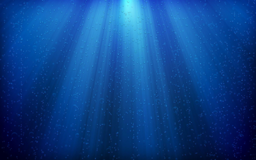

In [14]:
from fastdownload import download_url
dest = 'non_human.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'human photos'


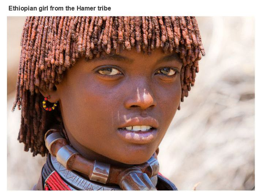

In [15]:
download_url(search_images('human photos', max_images=1)[0], 'human.jpg', show_progress=False)
Image.open('human.jpg').to_thumb(256,256)

In [20]:
!rm -rf "./human_or_not"
searches = 'humans','background'
path = Path('human_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    download_images(dest, urls=search_images(f'{o} sun'))
    download_images(dest, urls=search_images(f'{o} shade'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'humans'
Searching for 'humans sun'
Searching for 'humans shade'
Searching for 'background'
Searching for 'background sun'
Searching for 'background shade'


In [21]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

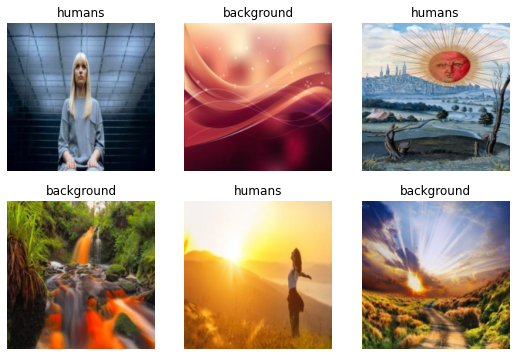

In [22]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

dls = db.dataloaders(path, bs=32)
dls.show_batch(max_n=6)

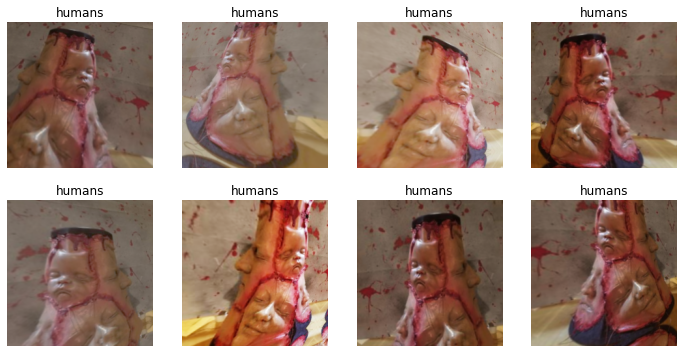

In [23]:
db = db.new(
                item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                batch_tfms=aug_transforms(mult=2)
               )
dls = db.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [24]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/app-root/lib64/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/app-root/lib64/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.182013,0.540964,0.333333,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.728638,0.245807,0.090909,00:18
1,0.504366,0.117491,0.000000,00:21
2,0.363272,0.049098,0.000000,00:22


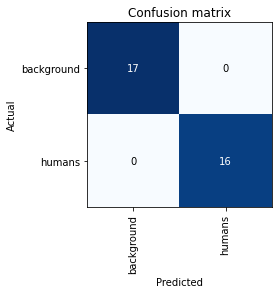

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [26]:
learn.export("./hnh_model.pkl")
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('hnh_model.pkl'),Path('export.pkl')]

In [27]:
model_inf = load_learner(path/'hnh_model.pkl')

In [29]:
model_inf.predict(random.choice(get_image_files(Path("human_or_not/background"))))

('humans', TensorBase(1), TensorBase([4.7063e-07, 1.0000e+00]))

In [35]:
chosen_image = random.choice(get_image_files(Path("human_or_not/background")))

In [37]:
is_human,_,probs = learn.predict(chosen_image)
print(f"This is a: {is_human}.")
print(f"Probability it's a kitten: {probs[0]:.4f}")

This is a: background.
Probability it's a kitten: 0.7373


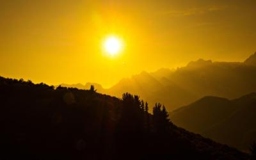

In [38]:
im = Image.open(chosen_image).to_thumb(256,256)
im.show()